<a href="https://colab.research.google.com/github/seokhee516/ML-DL-playground/blob/main/_%EA%B0%9D%EC%B2%B4_%ED%83%90%EC%A7%80_(Object_Detection)_YOLO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

- 참조 : https://github.com/wikibook/dl-vision

# 객체 탐지 (Object Detection)

- 한 이미지에서 객체와 그 경계 상자(bounding box)를 탐지

- 객체 탐지 알고리즘은 일반적으로 이미지를 입력으로 받고, 경계 상자와 객체 클래스 리스트를 출력

- 경계 상자에 대해 그에 대응하는 예측 클래스와 클래스의 신뢰도(confidence)를 출력

## Applications

- 자율 주행 자동차에서 다른 자동차와 보행자를 찾을 때

- 의료 분야에서 방사선 사진을 사용해 종양이나 위험한 조직을 찾을 때

- 제조업에서 조립 로봇이 제품을 조립하거나 수리할 때

- 보안 산업에서 위협을 탐지하거나 사람을 셀 때

## 용어 설명

### Boudning Box

- 이미지에서 하나의 객체 전체를 포함하는 가장 작은 직사각형

  <img src="https://miro.medium.com/max/850/1*KL6r494Eyfh3iYEXQA2tzg.png">

  <sub>[이미지 출처] https://medium.com/anolytics/how-bounding-box-annotation-helps-object-detection-in-machine-learning-use-cases-431d93e7b25b</sub>

### IOU(Intersection Over Union)
- 실측값(Ground Truth)과 모델이 예측한 값이 얼마나 겹치는지를 나타내는 지표

  <img src="https://pyimagesearch.com/wp-content/uploads/2016/09/iou_equation.png" width="300">

- IOU가 높을수록 잘 예측한 모델

  <img src="https://pyimagesearch.com/wp-content/uploads/2016/09/iou_examples.png" width="400">

<br>

- 예시
  <img src="https://www.pyimagesearch.com/wp-content/uploads/2016/09/iou_stop_sign.jpg">

  <sub>[이미지 출처] https://www.pyimagesearch.com/2016/11/07/intersection-over-union-iou-for-object-detection/</sub>

In [ ]:
def compute_iou(pred_box, gt_box):
  x1 = np.maximum(pred_box[0], gt_box[0])
  y1 = np.maximum(pred_box[1], gt_box[1])
  x2 = np.maximum(pred_box[2], gt_box[2])
  y2 = np.maximum(pred_box[3], gt_box[3])

  intersection = np.maximum(x2 - x1, 0) * np.maximum(y2 - y1, 0)

  pred_box_area = (pred_box[2] - pred_box[0]) * (pred_box[3] - pred_box[1])
  gt_box_area = (gt_box[2] - gt_box[0]) * (gt_box[3] - gt_box[1])
  union = pred_box_area + gt_box_area - intersection_area

  iou = intersection / union

  return iou

### NMS(Non-Maximum Suppression, 비최댓값 억제)

- 확률이 가장 높은 상자와 겹치는 상자들을 제거하는 과정

- 최댓값을 갖지 않는 상자들을 제거

- 과정

  1. 확률 기준으로 모든 상자를 정렬하고 먼저 가장 확률이 높은 상자를 취함

  2. 각 상자에 대해 다른 모든 상자와의 IOU를 계산

  3. 특정 임곗값을 넘는 상자는 제거

  <img src="https://pyimagesearch.com/wp-content/uploads/2014/10/nms_fast_03.jpg">

  <sub>[이미지 출처] https://www.pyimagesearch.com/2015/02/16/faster-non-maximum-suppression-python/</sub>

In [ ]:
import numpy as np
def non_max_surppression_fast(boxes, overlap_thresh):
  if len(boxes) == 0:
    return []
  
  if boxes.dtype.kind == 'i':
    boxes = boxes.astype('float')
  
  pick = []
  x1 = boxes[:, 0]
  y1 = boxes[:, 1]
  x2 = boxes[:, 2]
  y2 = boxes[:, 3]

  area = (x2 - x1 +1) * (y2 - y1 + 1)
  idxs = np.argsort(y2)
  
  while len(idxs) > 0:
    last = len(idxs) - 1
    i = idxs[last]
    pick.append(i)

    xx1 = np.maximum(x1[i], x1[idxs[:last]])
    yy1 = np.maximum(y1[i], y1[idxs[:last]])
    xx2 = np.maximum(x2[i], x2[idxs[:last]])
    yy2 = np.maximum(y2[i], y2[idxs[:last]])

    w = np.maximum(0, xx2 - xx1 + 1)
    h = np.maximum(0, yy2 - yy1 + 1)

    overlap = (w * h) /area[idxs[:last]]

    idxs = np.delete(idxs, np.concatenate(([last], np.where(overlap > overlap_thresh)[0])))
  return boxes[pick].astype('int')

## 모델 성능 평가

### 정밀도와 재현율

- 일반적으로 객체 탐지 모델 평가에 사용되지는 않지만, 다른 지표를 계산하는 기본 지표 역할을 함

  - `TP` 

    - True Positives

    - 예측이 동일 클래스의 실제 상자와 일치하는지 측정

  - `FP`

    - False Positives

    - 예측이 실제 상자와 일치하지 않는지 측정

  - `FN`

    - False Negatives

    - 실제 분류값이 그와 일치하는 예측을 갖지 못하는지 측정

<br>

## $\qquad precision = \frac{TP}{TP \ + \ FP}$
## $\qquad recall = \frac{TP}{TP \ + \ FN}$

  - 모델이 안정적이지 않은 특징을 기반으로 객체 존재를 예측하면 거짓긍정(FP)이 많아져서 정밀도가 낮아짐

  - 모델이 너무 엄격해서 정확한 조건을 만족할 때만 객체가 탐지된 것으로 간주하면 거짓부정(FN)이 많아져서 재현율이 낮아짐



### 정밀도-재현율 곡선(precision-recall curve) 

- 신뢰도 임곗값마다 모델의 정밀도와 재현율을 시각화

- 모든 bounding box와 함께 모델이 예측의 정확성을 얼마나 확실하는지 0 ~ 1사이의 숫자로 나타내는 신뢰도를 출력

- 임계값 T에 따라 정밀도와 재현율이 달라짐

  - 임곗값 T 이하의 예측은 제거함

  - T가 1에 가까우면 정밀도는 높지만 재현율은 낮음  
    놓치는 객체가 많아져서 재현율이 낮아짐. 즉, 신뢰도가 높은 예측만 유지하기때문에 정밀도는 높아짐

  - T가 0에 가까우면 정밀도는 낮지만 재현율은 높음  
    대부분의 예측을 유지하기때문에 재현율은 높아지고, 거짓긍정(FP)이 많아져서 정밀도가 낮아짐

- 예를 들어, 모델이 보행자를 탐지하고 있으면 특별한 이유없이 차를 세우더라도 어떤 보행자도 놓치지 않도록 재현율을 높여야 함
  모델이 투자 기회를 탐지하고 있다면 일부 기회를 놓치게 되더라도 잘못된 기회에 돈을 거는 일을 피하기 위해 정밀도를 높여야 함

<img src="https://www.researchgate.net/profile/Davide_Chicco/publication/321672019/figure/fig1/AS:614279602511886@1523467078452/a-Example-of-Precision-Recall-curve-with-the-precision-score-on-the-y-axis-and-the.png">

<sub>[이미지 출처] https://www.researchgate.net/figure/a-Example-of-Precision-Recall-curve-with-the-precision-score-on-the-y-axis-and-the_fig1_321672019</sub>

### AP (Average Precision, 평균 정밀도) 와 mAP(mean Average Precision)

- 곡선의 아래 영역에 해당

- 항상 1x1 정사각형으로 구성되어 있음  
  즉, 항상 0 ~ 1 사이의 값을 가짐

- 단일 클래스에 대한 모델 성능 정보를 제공

- 전역 점수를 얻기위해서 mAP를 사용

- 예를 들어, 데이터셋이 10개의 클래스로 구성된다면 각 클래스에 대한 AP를 계산하고, 그 숫자들의 평균을 다시 구함

- (참고)

  - 최소 2개 이상의 객체를 탐지하는 대회인 PASCAL Visual Object Classes와 Common Objects in Context(COCO)에서 mAP가 사용됨

  - COCO 데이터셋이 더 많은 클래스를 포함하고 있기 때문에 보통 Pascal VOC보다 점수가 더 낮게 나옴

  - 예시

    <img src="https://www.researchgate.net/profile/Bong_Nam_Kang/publication/328939155/figure/tbl2/AS:692891936649218@1542209719916/Evaluation-on-PASCAL-VOC-2007-and-MS-COCO-test-dev.png">

    <sub>[이미지 출처] https://www.researchgate.net/figure/Evaluation-on-PASCAL-VOC-2007-and-MS-COCO-test-dev_tbl2_328939155</sub>

## Dataset

### VOC

- 2005년부터 2012년까지 진행

- Object Detection 기술의 benchmark로 간주

- 데이터셋에는 20개의 클래스가 존재

      background
      aeroplane
      bicycle
      bird
      boat
      bottle
      bus
      car
      cat
      chair
      cow
      diningtable
      dog
      horse
      motorbike
      person
      pottedplant
      sheep
      sofa
      train
      tvmonitor

- 훈련 및 검증 데이터 : 11,530개

- ROI에 대한 27,450개의 Annotation이 존재

- 이미지당 2.4개의 객체 존재

  <img src="https://paperswithcode.github.io/sotabench-eval/img/pascalvoc2012.png">

  <sub>[이미지 출처] https://paperswithcode.github.io/sotabench-eval/pascalvoc/</sub>

### COCO Dataset

- Common Objects in Context

- 200,000개의 이미지 

- 80개의 카테고리에 500,000개 이상의 객체 Annotation이 존재
      person
      bicycle
      car
      motorbike
      aeroplane
      bus
      train
      truck
      boat
      traffic light
      fire hydrant
      stop sign
      parking meter
      bench
      bird
      cat
      dog
      horse
      sheep
      cow
      elephant
      bear
      zebra
      giraffe
      backpack
      umbrella
      handbag
      tie
      suitcase
      frisbee
      skis
      snowboard
      sports ball
      kite
      baseball bat
      baseball glove
      skateboard
      surfboard
      tennis racket
      bottle
      wine glass
      cup
      fork
      knife
      spoon
      bowl
      banana
      apple
      sandwich
      orange
      broccoli
      carrot
      hot dog
      pizza
      donut
      cake
      chair
      sofa
      pottedplant
      bed
      diningtable
      toilet
      tvmonitor
      laptop
      mouse
      remote
      keyboard
      cell phone
      microwave
      oven
      toaster
      sink
      refrigerator
      book
      clock
      vase
      scissors
      teddy bear
      hair drier
      toothbrush
- https://cocodataset.org/#home

<img src="https://cocodataset.org/images/coco-examples.jpg">



# YOLO (You Only Look Once)

- 가장 빠른 객체 검출 알고리즘 중 하나

- 256x256 사이즈의 이미지

- GPU 사용 시, 초당 170프레임(170**FPS**, **frames per second**),  
  이는 파이썬, 텐서플로 기반 프레임워크가 아닌 C++로 구현된 코드 기준

- 작은 크기의 물체를 탐지하는데는 어려움

<img src="https://miro.medium.com/max/1400/1*bSLNlG7crv-p-m4LVYYk3Q.png" width="600">


- https://pjreddie.com/darknet/yolo/

- 자세한 내용 참조 : https://www.kaggle.com/aruchomu/yolo-v3-object-detection-in-tensorflow

## YOLO Backbone

- 백본 모델(backbone model) 기반

- 특징 추출기(Feature Extractor)라고도 불림

- YOLO는 자체 맞춤 아키텍쳐 사용

- 어떤 특징 추출기 아키텍쳐를 사용했는지에 따라 성능 달라짐

  <img src="https://www.researchgate.net/publication/335865923/figure/fig1/AS:804106595758082@1568725360777/Structure-detail-of-YOLOv3It-uses-Darknet-53-as-the-backbone-network-and-uses-three.jpg">

  <sub>[이미지 출처] https://www.researchgate.net/figure/Structure-detail-of-YOLOv3It-uses-Darknet-53-as-the-backbone-network-and-uses-three_fig1_335865923</sub>

- 마지막 계층은 크기가 $w \times h \times D$인 특징 볼륨 출력

- $w \times h $는 그리드의 크기이고, $D$는 특징 볼륨 깊이



## YOLO의 계층 출력

- 마지막 계층 출력은 $w \times h \times M$ 행렬
  
  - $M = B \times (C + 5)$

    - B : 그리드 셀당 경계 상자 개수

    - C : 클래스 개수

  - 클래스 개수에 5를 더한 이유는 해당 값 만큼의 숫자를 예측해야함

    - $t_x$, $t_y$는 경계상자의 중심 좌표를 계산

    - $t_w$, $t_h$는 경계상자의 너비와 높이를 계산

    - $c$는 객체가 경계 상자 안에 있다고 확신하는 신뢰도

    - $p1, p2, ..., pC$는 경계상자가 클래스 1, 2, ..., C의 객체를 포함할 확률
  
  <br>

  <img src="https://www.researchgate.net/profile/Thi_Le3/publication/337705605/figure/fig3/AS:831927326089217@1575358339500/Structure-of-one-output-cell-in-YOLO.ppm">

  <sub>[이미지 출처] https://www.researchgate.net/figure/Structure-of-one-output-cell-in-YOLO_fig3_337705605</sub>

## 앵커 박스(Anchor Box)

- YOLOv2에서 도입

- 사전 정의된 상자(prior box)

- 객체에 가장 근접한 앵커 박스를 맞추고 신경망을 사용해 앵커 박스의 크기를 조정하는 과정때문에 $t_x, t_y, t_w, t_h$이 필요

  <img src="https://kr.mathworks.com/help/vision/ug/ssd_detection.png">

  <sub>[이미지 출처] https://kr.mathworks.com/help/vision/ug/getting-started-with-yolo-v2.html</sub>

# YOLOv3 Inference 연습 : tensorflow 2

- 코드 참조 : https://github.com/zzh8829/yolov3-tf2

## Clone and install dependencies

In [1]:
! git clone https://github.com/zzh8829/yolov3-tf2

Cloning into 'yolov3-tf2'...
remote: Enumerating objects: 439, done.
remote: Counting objects: 100% (27/27), done.
remote: Compressing objects: 100% (27/27), done.
remote: Total 439 (delta 10), reused 3 (delta 0), pack-reused 412
Receiving objects: 100% (439/439), 4.25 MiB | 9.95 MiB/s, done.
Resolving deltas: 100% (247/247), done.


In [2]:
%cd yolov3-tf2/

/content/yolov3-tf2


In [3]:
!pip install -r requirements-gpu.txt

Obtaining file:///content/yolov3-tf2 (from -r requirements-gpu.txt (line 6))
     |████████████████████████████████| 421.8 MB 2.5 kB/s 
     |████████████████████████████████| 20.1 MB 69.1 MB/s 
     |████████████████████████████████| 50 kB 8.0 MB/s 
     |████████████████████████████████| 41 kB 801 kB/s 
     |████████████████████████████████| 448 kB 68.4 MB/s 
     |████████████████████████████████| 3.8 MB 72.5 MB/s 
  Created wheel for gast: filename=gast-0.2.2-py3-none-any.whl size=7554 sha256=34349a2b0f4561d154641ab4fce081f11458e4c3c961287595c01a089db165e6
  Stored in directory: /root/.cache/pip/wheels/21/7f/02/420f32a803f7d0967b48dd823da3f558c5166991bfd204eef3
Successfully built gast
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.5.0
    Uninstalling tensorflow-estimator-2.5.0:


In [4]:
!ls

checkpoints	 data		  README.md		train.py
colab_gpu.ipynb  detect.py	  requirements-gpu.txt	yolov3_tf2
conda-cpu.yml	 detect_video.py  requirements.txt	yolov3_tf2.egg-info
conda-gpu.yml	 docs		  setup.py
convert.py	 LICENSE	  tools


## Check Tensorflow2 version

In [4]:
import tensorflow as tf
tf.__version__

'2.1.2'

## Convert Pretrained Darknet Weight

- https://pjreddie.com/media/files/yolov3.weights
- `yolov3.weights`를 `/yolov3-tf2/data/`로 넣기

In [19]:
!wget https://pjreddie.com/media/files/yolov3.weights -O data/yolov3.weights

--2022-02-11 08:36:50--  https://pjreddie.com/media/files/yolov3.weights
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248007048 (237M) [application/octet-stream]
Saving to: ‘data/yolov3.weights’

data/yolov3.weights 100%[===================>] 236.52M  41.9MB/s    in 5.9s    

2022-02-11 08:36:56 (40.3 MB/s) - ‘data/yolov3.weights’ saved [248007048/248007048]



In [20]:
!python convert.py

2022-02-11 08:37:01.538162: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libnvinfer.so.6'; dlerror: libnvinfer.so.6: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2022-02-11 08:37:01.538262: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libnvinfer_plugin.so.6'; dlerror: libnvinfer_plugin.so.6: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2022-02-11 08:37:01.538281: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:30] Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.
2022-02-11 08:37:02.351122: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2022-02-11 08:37:02.355465: I tensorflow/stream_executor/cuda/cuda_g

## Initial Detector

In [21]:
import sys 
from absl import app, logging, flags
from absl.flags import FLAGS
import time
import cv2
import numpy as np
import tensorflow as tf
from yolov3_tf2.models import YoloV3, YoloV3Tiny
from yolov3_tf2.dataset import transform_images, load_tfrecord_dataset
from yolov3_tf2.utils import draw_outputs

In [22]:
flags.DEFINE_string('classes', './data/coco.names', 'path to classes file')
flags.DEFINE_string('weights', './checkpoints/yolov3.tf','path to weights file')
flags.DEFINE_boolean('tiny', False, 'yolov3 or yolov3-tiny')
flags.DEFINE_integer('size', 416, 'resize images to')
flags.DEFINE_string('image', './data/girl.png', 'path to input image')
flags.DEFINE_string('tfrecord', None, 'tfrecord instead of image')
flags.DEFINE_string('output', './output.jpg', 'path to output image')
flags.DEFINE_integer('num_classes', 80, 'number of classes in the model')

app._run_init(['yolov3'], app.parse_flags_with_usage)

physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

DuplicateFlagError: ignored

## Detect Image

In [9]:
FLAGS.image = 'data/meme.jpg'

In [29]:
FLAGS.image = 'data/girl.png'

In [30]:
if FLAGS.tiny:
    yolo = YoloV3Tiny(classes=FLAGS.num_classes)
else:
    yolo = YoloV3(classes=FLAGS.num_classes)
      
yolo.load_weights(FLAGS.weights).expect_partial()
logging.info('weights loaded')

class_names = [c.strip() for c in open(FLAGS.classes).readlines()]
logging.info('classes loaded')

I0211 08:43:25.805676 140397767817088 <ipython-input-30-1973340ba6b4>:7] weights loaded
I0211 08:43:25.807335 140397767817088 <ipython-input-30-1973340ba6b4>:10] classes loaded


In [31]:
img_raw = tf.image.decode_image(open(FLAGS.image, 'rb').read(), channels=3)
img = tf.expand_dims(img_raw, 0)
img = transform_images(img, FLAGS.size)

t1 = time.time()
boxes, scores, classes, nums = yolo(img)
t2 = time.time()
logging.info('time: {}'.format(t2 - t1))

logging.info('detections:')
for i in range(nums[0]):
    logging.info('\t{}, {}, {}'.format(class_names[int(classes[0][i])],
                                        np.array(scores[0][i]),
                                        np.array(boxes[0][i])))

img = cv2.cvtColor(img_raw.numpy(), cv2.COLOR_RGB2BGR)
img = draw_outputs(img, (boxes, scores, classes, nums), class_names)

I0211 08:43:26.010945 140397767817088 <ipython-input-31-428c311451ce>:8] time: 0.1634504795074463
I0211 08:43:26.011921 140397767817088 <ipython-input-31-428c311451ce>:10] detections:
I0211 08:43:26.016302 140397767817088 <ipython-input-31-428c311451ce>:14] 	person, 0.9997697472572327, [0.06754467 0.03718692 0.967988   0.9650753 ]
I0211 08:43:26.019356 140397767817088 <ipython-input-31-428c311451ce>:14] 	chair, 0.9255481958389282, [0.01851872 0.34200278 0.17385136 0.6278329 ]


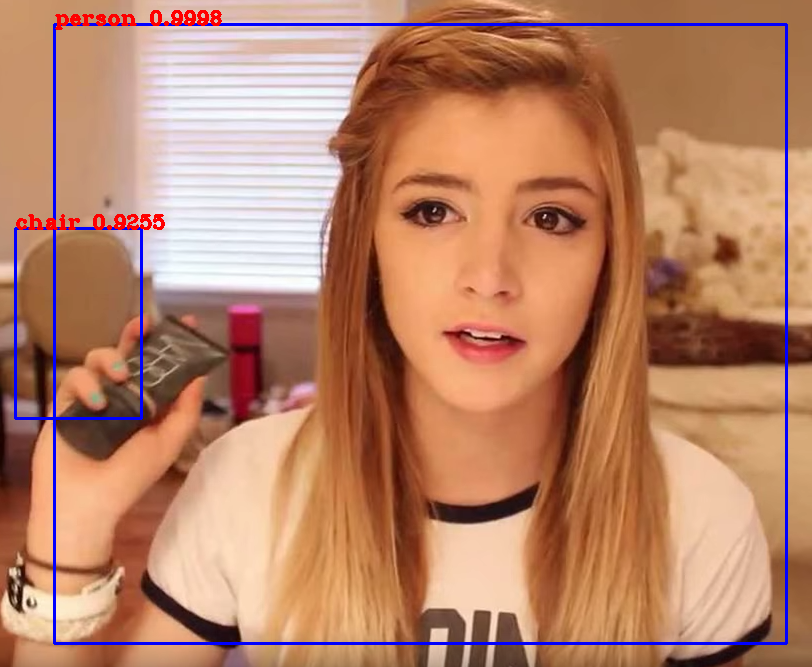

In [32]:
from IPython.display import Image, display
display(Image(data=bytes(cv2.imencode('.png', img)[1]), width=800))

# YOLOv3 inference 연습 : Pytorch 

- video inference
- 코드 참조 : https://towardsdatascience.com/yolov3-pytorch-on-google-colab-c4a79eeecdea
- https://github.com/ultralytics/yolov3

## Prepare YOLOv3-pytorch

## Git clone to get short videos

- https://github.com/vindruid/yolov3-in-colab.git

## Process Video

- Custom Data Train 참고

  - https://github.com/AntonMu/TrainYourOwnYOLO